In [1]:
import os
import torch
import pandas as pd
import numpy as np
from scipy.io import loadmat
import matplotlib.pyplot as plt

In [2]:
list_dirs = [
    "Healthy",
    "Motor_1_Steady_state_error",
    "Motor_1_Stuck",
    "Motor_2_Steady_state_error",
    "Motor_2_Stuck",
    "Motor_3_Steady_state_error",
    "Motor_3_Stuck",
    "Motor_4_Steady_state_error",
    "Motor_4_Stuck"
]

train_path = "dataset/trainingDatasets/20241017/"
test_path = "dataset/testDatasets/20241016/"

device = torch.device("mps")

In [3]:
if not os.path.exists("./set_csv/"):
    os.makedirs("./set_csv/training_set")
    os.mkdir("./set_csv/testing_set")

    for dir in list_dirs:
        os.mkdir(f"./set_csv/training_set/{dir}")
        os.mkdir(f"./set_csv/testing_set/{dir}")

for dir in list_dirs:
    with os.scandir(train_path + dir) as it:
        for file in it:
            if os.path.splitext(file.path)[1] == ".mat" and file.name[0] != "h":
                dataframe = loadmat(file.path)
                dataframe = np.concatenate((dataframe["trajCmds"], dataframe["trajResps"]), axis=1)
                dataframe = pd.DataFrame(dataframe)
                name = os.path.splitext(file.name)[0] + ".csv"
                dataframe.to_csv(f"./set_csv/training_set/{dir}/{name}")
                print(f"./set_csv/training_set/{dir}/{name}")
                    
    
    with os.scandir(test_path + dir) as it:
        for file in it:
            if os.path.splitext(file.path)[1] == ".mat" and file.name[0] != "h":
                dataframe = loadmat(file.path)
                dataframe = np.concatenate((dataframe["trajCmds"], dataframe["trajResps"]), axis=1)
                dataframe = pd.DataFrame(dataframe)
                name = os.path.splitext(file.name)[0] + ".csv"
                dataframe.to_csv(f"./set_csv/testing_set/{dir}/{name}")
                print(f"./set_csv/testing_set/{dir}/{name}")

train_path = "set_csv/training_set/"
test_path = "set_csv/testing_set/"

./set_csv/training_set/Healthy/dataset_123.csv
./set_csv/training_set/Healthy/dataset_137.csv
./set_csv/training_set/Healthy/dataset_48.csv
./set_csv/training_set/Healthy/dataset_60.csv
./set_csv/training_set/Healthy/dataset_74.csv
./set_csv/training_set/Healthy/dataset_321.csv
./set_csv/training_set/Healthy/dataset_335.csv
./set_csv/training_set/Healthy/dataset_2.csv
./set_csv/training_set/Healthy/dataset_309.csv
./set_csv/training_set/Healthy/dataset_255.csv
./set_csv/training_set/Healthy/dataset_241.csv
./set_csv/training_set/Healthy/dataset_269.csv
./set_csv/training_set/Healthy/dataset_296.csv
./set_csv/training_set/Healthy/dataset_282.csv
./set_csv/training_set/Healthy/dataset_283.csv
./set_csv/training_set/Healthy/dataset_297.csv
./set_csv/training_set/Healthy/dataset_268.csv
./set_csv/training_set/Healthy/dataset_240.csv
./set_csv/training_set/Healthy/dataset_254.csv
./set_csv/training_set/Healthy/dataset_308.csv
./set_csv/training_set/Healthy/dataset_334.csv
./set_csv/training

In [4]:
for dir in list_dirs:
    for sub_dir in (train_path, test_path):
        with os.scandir(sub_dir + dir) as it:
            for file in it:
                if file.name[-5] == ")":
                    os.remove(file.path)
                    print(file.path)

In [5]:
train_list = []
test_list = []

for dir in list_dirs:
    train_category_list = []
    with os.scandir(train_path + dir) as it:
        for file in it:
            tensor = torch.tensor(np.array(pd.read_csv(file.path)))
            assert tensor.shape == (1000, 7)
            train_category_list.append(tensor)
        train_category_tensor = torch.stack(train_category_list)
        assert train_category_tensor.shape == (400, 1000, 7)
    train_list.append(train_category_tensor)

    test_category_list = []
    with os.scandir(test_path + dir) as it:
        for file in it:
            tensor = torch.tensor(np.array(pd.read_csv(file.path)))
            assert tensor.shape == (1000, 7)
            test_category_list.append(tensor)
        test_category_tensor = torch.stack(test_category_list)
        assert test_category_tensor.shape == (10, 1000, 7)
    test_list.append(test_category_tensor)

train_tensor = torch.stack(train_list)
test_tensor = torch.stack(test_list)

assert train_tensor.shape == (9, 400, 1000, 7)
assert test_tensor.shape == (9, 10, 1000, 7)

In [6]:
train_tensor.to(torch.float32).to(device)
test_tensor.to(torch.float32).to(device)

similarities = torch.empty((9, 400)).to(device)
for n in range(9):
    for i, tensor in enumerate(train_tensor[n]):
        pre_score = torch.nn.functional.cosine_similarity(tensor[:,1:], test_tensor[:,:,:,1:], dim=2)
        score = torch.max(torch.mean(pre_score, dim=2))
        similarities[n][i] = score

13


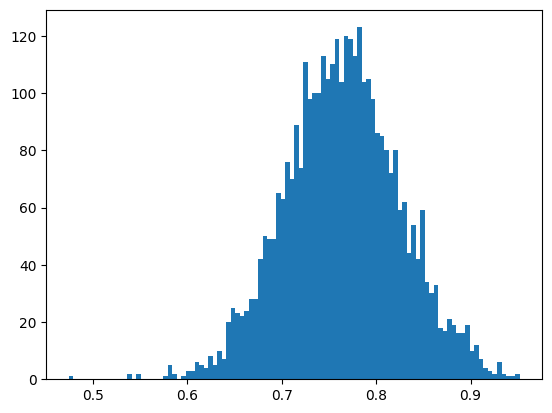

In [24]:
#similarities = similarities.cpu().numpy()
print(min(np.count_nonzero(similarities >= 0.85, axis=1)))

plt.hist(similarities.flat, bins=100)
plt.show()

In [16]:
differences = []
for train_label, test_label in zip(train_tensor, test_tensor):
    label_list = []
    for tensor in train_label:
        difference = torch.mean(test_label - tensor, dim=0)
        label_list.append(difference)
    label_tensor = torch.stack(label_list)
    differences.append(label_tensor)
differences = torch.stack(differences)

expectency = torch.mean(differences, dim=1)
std = torch.std(differences, dim=1)
print(expectency.shape, std.shape)

torch.Size([9, 1000, 7]) torch.Size([9, 1000, 7])


In [19]:
high_quality = [category[similarities[n] > 0.85][:12] for n, category in enumerate(train_tensor.cpu())]
high_quality = torch.stack(high_quality)
print(high_quality.shape)

torch.Size([9, 12, 1000, 7])


In [21]:
for dir in list_dirs:
    if not os.path.exists(f"set_csv/augmented/{dir}"):
        os.makedirs(f"set_csv/augmented/{dir}")

for high_quality_label, label in zip(high_quality, list_dirs):
    for m, high_quality_tensor in enumerate(high_quality_label):
        for k in range(12):
            noised_tensor = high_quality_tensor + torch.normal(expectency[n], std[n])
            assert noised_tensor.shape == (1000, 7)
            dataframe = pd.DataFrame(noised_tensor.numpy())
            dataframe.to_csv(f"set_csv/augmented/{label}/dataset_{m*12+k+1}.csv")
            print(f"set_csv/augmented/{label}/dataset_{m*12+k+1}.csv")

set_csv/augmented/Healthy/dataset_1.csv
set_csv/augmented/Healthy/dataset_2.csv
set_csv/augmented/Healthy/dataset_3.csv
set_csv/augmented/Healthy/dataset_4.csv
set_csv/augmented/Healthy/dataset_5.csv
set_csv/augmented/Healthy/dataset_6.csv
set_csv/augmented/Healthy/dataset_7.csv
set_csv/augmented/Healthy/dataset_8.csv
set_csv/augmented/Healthy/dataset_9.csv
set_csv/augmented/Healthy/dataset_10.csv
set_csv/augmented/Healthy/dataset_11.csv
set_csv/augmented/Healthy/dataset_12.csv
set_csv/augmented/Healthy/dataset_13.csv
set_csv/augmented/Healthy/dataset_14.csv
set_csv/augmented/Healthy/dataset_15.csv
set_csv/augmented/Healthy/dataset_16.csv
set_csv/augmented/Healthy/dataset_17.csv
set_csv/augmented/Healthy/dataset_18.csv
set_csv/augmented/Healthy/dataset_19.csv
set_csv/augmented/Healthy/dataset_20.csv
set_csv/augmented/Healthy/dataset_21.csv
set_csv/augmented/Healthy/dataset_22.csv
set_csv/augmented/Healthy/dataset_23.csv
set_csv/augmented/Healthy/dataset_24.csv
set_csv/augmented/Healthy